In [7]:
pip install qiskit-nature qiskit-algorithms qiskit-ibm-runtime pyscf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.5/378.5 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.0 MB/s eta 0:00:00


--- Step 1: Classical & Simulator (Training) ---
Dist: 1.0Å | Classical: -9.3720 | Sim VQE: -7.7743
Dist: 1.5Å | Classical: -8.9407 | Sim VQE: -7.0047
Dist: 2.0Å | Classical: -8.6549 | Sim VQE: -6.9129
Dist: 2.5Å | Classical: -8.4587 | Sim VQE: -6.9503
Dist: 3.0Å | Classical: -8.3280 | Sim VQE: -7.2692
Dist: 3.5Å | Classical: -8.2417 | Sim VQE: -6.9528

--- Step 2: Running Verification on [Fez, Marrakesh, Torino] ---

Submitting to ibm_fez...
  Transpiling circuit for ibm_fez...
  Job ID: d5dp0epsmlfc739oj9ng (Waiting in Queue...)
  Success! ibm_fez Energy: -6.822343573084552

Submitting to ibm_marrakesh...
  Transpiling circuit for ibm_marrakesh...
  Job ID: d5dp257p3tbc73b06vig (Waiting in Queue...)
  Success! ibm_marrakesh Energy: -6.914370076224095

Submitting to ibm_torino...
  Transpiling circuit for ibm_torino...
  Job ID: d5dp4ognsj9s73baoh50 (Waiting in Queue...)
  Success! ibm_torino Energy: -6.759602923350714

--- Step 3: Generating Visualizations ---


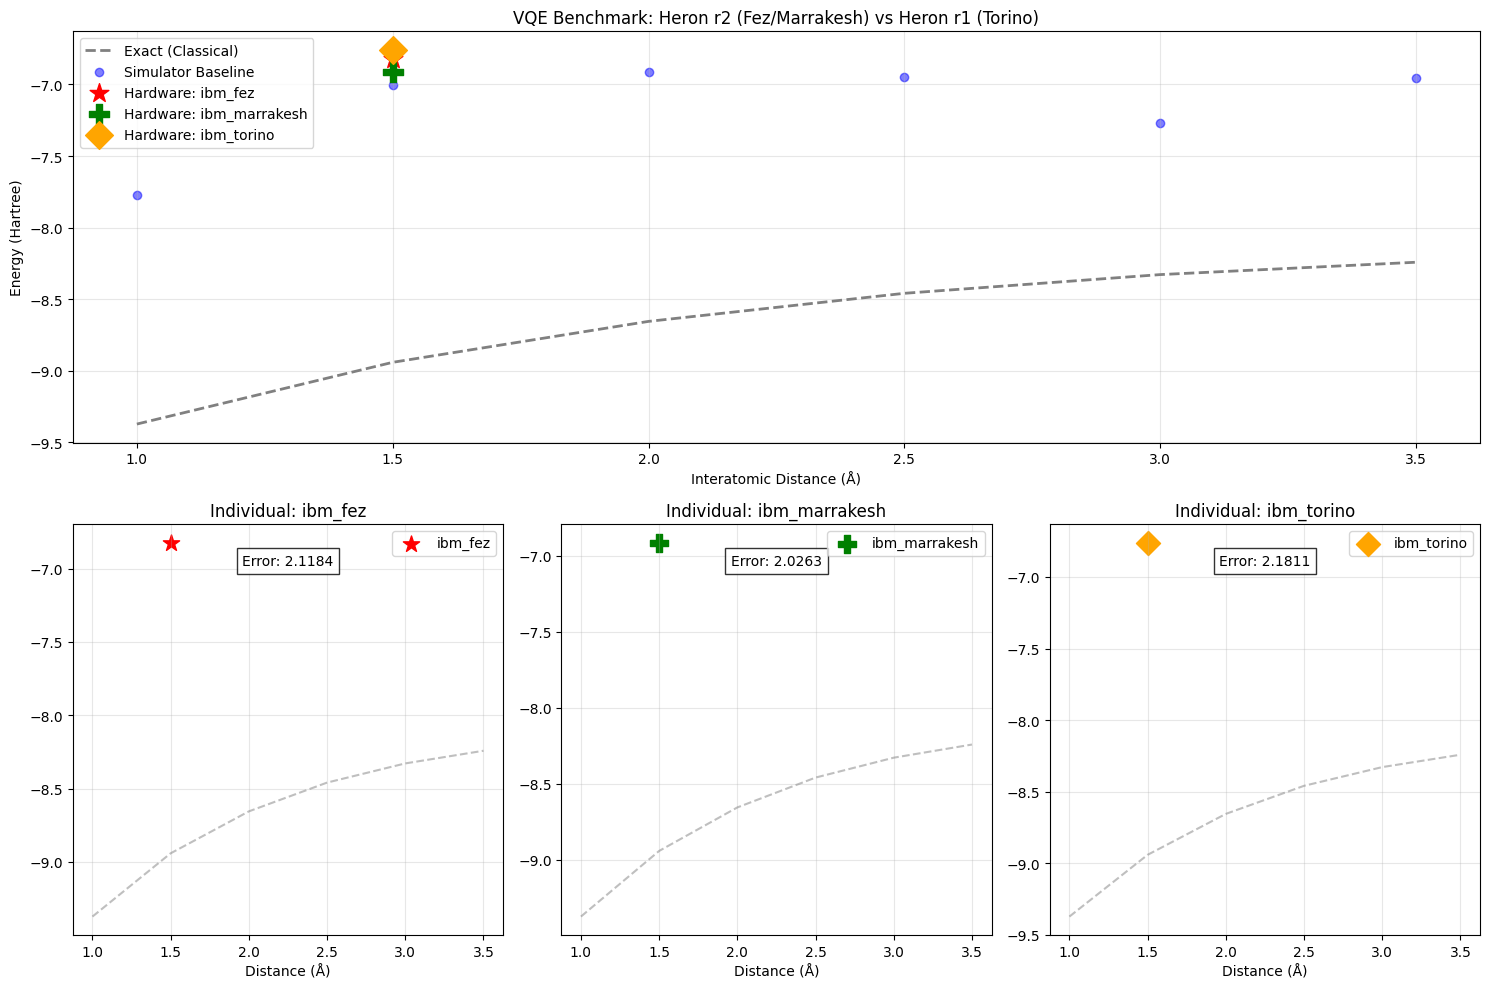

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

from qiskit import transpile
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms import VQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import COBYLA
from qiskit.circuit.library import EfficientSU2
from qiskit.primitives import StatevectorEstimator
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as RuntimeEstimator


distances = np.arange(1.0, 4.0, 0.5)
exact_energies = []
vqe_sim_energies = []

optimal_params_at_1_5 = None
driver_at_1_5 = None

print("--- Step 1: Classical & Simulator (Training) ---")

for dist in distances:
    driver = PySCFDriver(
        atom=f"Li 0 0 0; H 0 0 {dist}",
        basis='sto-3g',
        charge=0, spin=0, unit=DistanceUnit.ANGSTROM
    )
    problem = driver.run()
    qubit_op = JordanWignerMapper().map(problem.hamiltonian.second_q_op())

    # Classical
    solver = NumPyMinimumEigensolver()
    result = solver.compute_minimum_eigenvalue(qubit_op)
    exact_energies.append(result.eigenvalue.real)

    # VQE Simulator
    ansatz = EfficientSU2(qubit_op.num_qubits, entanglement='linear')
    # maxiter=200 to improve accuracy
    optimizer = COBYLA(maxiter=200)
    vqe = VQE(StatevectorEstimator(), ansatz, optimizer)
    vqe_result = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_sim_energies.append(vqe_result.eigenvalue.real)

    print(f"Dist: {dist}Å | Classical: {result.eigenvalue.real:.4f} | Sim VQE: {vqe_result.eigenvalue.real:.4f}")

    if dist == 1.5:
        optimal_params_at_1_5 = vqe_result.optimal_point
        driver_at_1_5 = qubit_op

# Hardware
print("\n--- Step 2: Running Verification on [Fez, Marrakesh, Torino] ---")

token = "TOKEN"
instance = "CRN"

QiskitRuntimeService.save_account(
    token=token,
    channel="ibm_cloud",
    instance=instance,
    name="NAME",
    overwrite=True
)
service = QiskitRuntimeService(name="NAME")

target_backends = ["ibm_fez", "ibm_marrakesh", "ibm_torino"]
hardware_results = {}

ansatz_hw = EfficientSU2(driver_at_1_5.num_qubits, entanglement='linear')

for backend_name in target_backends:
    try:
        print(f"\nSubmitting to {backend_name}...")
        backend = service.backend(backend_name)

        print(f"  Transpiling circuit for {backend_name}...")

        isa_circuit = transpile(ansatz_hw, backend=backend, optimization_level=1)

        isa_observable = driver_at_1_5.apply_layout(isa_circuit.layout)

        pub = (isa_circuit, isa_observable, optimal_params_at_1_5)

        estimator_hw = RuntimeEstimator(mode=backend)

        # Run the job
        job = estimator_hw.run([pub])
        print(f"  Job ID: {job.job_id()} (Waiting in Queue...)")

        result = job.result()
        energy = result[0].data.evs
        hardware_results[backend_name] = energy
        print(f"  Success! {backend_name} Energy: {energy}")

    except Exception as e:
        print(f"  Failed on {backend_name}: {e}")
        hardware_results[backend_name] = None

# --- 3. VISUALIZATION (Comparison) ---
print("\n--- Step 3: Generating Visualizations ---")

fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 3)

# Main Plot
ax_main = fig.add_subplot(gs[0, :])
ax_main.plot(distances, exact_energies, label="Exact (Classical)", color='gray', linestyle='--', linewidth=2)
ax_main.scatter(distances, vqe_sim_energies, label="Simulator Baseline", color='blue', alpha=0.5)

colors = {'ibm_fez': 'red', 'ibm_marrakesh': 'green', 'ibm_torino': 'orange'}
markers = {'ibm_fez': '*', 'ibm_marrakesh': 'P', 'ibm_torino': 'D'}

for name, energy in hardware_results.items():
    if energy is not None:
        ax_main.scatter([1.5], [energy], color=colors[name], marker=markers[name], s=200, label=f"Hardware: {name}", zorder=10)

ax_main.set_title("VQE Benchmark: Heron r2 (Fez/Marrakesh) vs Heron r1 (Torino)")
ax_main.set_ylabel("Energy (Hartree)")
ax_main.set_xlabel("Interatomic Distance (Å)")
ax_main.legend()
ax_main.grid(True, alpha=0.3)

# Individual Plots
for i, name in enumerate(target_backends):
    ax = fig.add_subplot(gs[1, i])
    ax.plot(distances, exact_energies, color='gray', linestyle='--', alpha=0.5)

    energy = hardware_results.get(name)
    if energy is not None:
        ax.scatter([1.5], [energy], color=colors[name], marker=markers[name], s=150, label=name)
        exact_at_1_5 = np.interp(1.5, distances, exact_energies)
        error = abs(energy - exact_at_1_5)
        ax.text(0.5, 0.9, f"Error: {error:.4f}", transform=ax.transAxes, ha='center', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

    ax.set_title(f"Individual: {name}")
    ax.set_xlabel("Distance (Å)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()